In [1]:
# ! pip3 install matplotlib
# ! pip install statsmodels
# ! pip install pmdarima

In [1]:
import os
import sys
import pandas as pd
from numpy.lib.stride_tricks import sliding_window_view

In [2]:
path_to_package = os.path.abspath(os.path.join('..'))
if path_to_package not in sys.path:
    sys.path.append(path_to_package)
    
from src.utils.data_model_region import Region

In [3]:
# Global Constants
# Dataset
DATA_DIR_PATH = "./../data"
DATASET_PATH = f"{DATA_DIR_PATH}/PRSA2017_Data_20130301-20170228"
DATSET_PREPROCESSED_PATH = f"{DATA_DIR_PATH}/preprocessed"

# Model 
RANDOM_STATE = 1
PAST_WINDOW = 1
FUTURE_WINDOW = 1
BATCH_SIZE = 2048*16
TEST_SIZE = 0.4

DATE_COLUMNS = ['year','month','day']
POLUTION_FEATURES = ["PM2.5","PM10","SO2","NO2","CO","O3"]



def get_preprocessed_dataset_path(region:Region, base_path:str=DATSET_PREPROCESSED_PATH)->str|None:
    """Get path to pre-processed dataset

    Args:
        region (Region): Specifies the region of the dataset
        base_path (str, optional): root dir of the dataset. Defaults to DATASET_PATH.

    Raises:
        ValueError: incorrect region provided

    Returns:
        str|None: returns the datset file path for the region or raises error
    """
    if type(region) == Region:
        return f"{base_path}/{region.value}.csv"
    else:
        raise ValueError("Unkown REGION name!!!")

In [4]:
regions_df = {}

for region in Region:
    # read datset
    regions_df[region] = pd.read_csv(get_preprocessed_dataset_path(region=region), index_col=None)
    # generate date
    regions_df[region]['date'] = pd.to_datetime(regions_df[region][DATE_COLUMNS])
    regions_df[region].drop(DATE_COLUMNS, axis=1, inplace=True)
    
    regions_df[region].drop('hour', axis=1, inplace=True)
    # group by daily and average
    regions_df[region] = regions_df[region].groupby('date').mean()
    
    # # set datetime index 
    # regions_df[region] = regions_df[region].set_index('date')

    # add week info
    regions_df[region]['week'] = regions_df[region].index.to_series().dt.isocalendar().week
    regions_df[region]['month'] = regions_df[region].index.to_series().dt.month
del region

In [5]:
# display sample
regions_df[Region.AOTIZHONGXIN]

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,N,S,E,W,week,month
date,,,,,,,,,,,,,,,,,
2013-03-01,7.125000,10.750000,11.708333,22.583333,429.166667,63.875000,1.391667,1026.875000,-18.745833,0.0,3.254167,1.000000,0.000000,0.291667,0.416667,9,3
2013-03-02,30.750000,42.083333,36.625000,66.666667,824.916667,29.750000,0.616667,1026.850000,-15.937500,0.0,1.479167,0.625000,0.208333,0.583333,0.375000,9,3
2013-03-03,76.916667,120.541667,61.291667,81.000000,1620.625000,19.125000,5.566667,1014.608333,-12.316667,0.0,1.658333,0.833333,0.083333,0.458333,0.375000,9,3
2013-03-04,22.708333,44.583333,23.015778,46.542748,595.019788,53.750000,9.962500,1017.650000,-11.683333,0.0,2.404167,0.500000,0.500000,0.208333,0.416667,10,3
2013-03-05,148.875000,183.791667,93.875000,132.833333,2357.958333,68.458333,6.291667,1010.900000,-7.525000,0.0,1.129167,0.833333,0.166667,0.708333,0.125000,10,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-24,21.541667,32.625000,16.583333,58.875000,575.000000,50.791667,5.166667,1021.012500,-11.141667,0.0,1.595833,0.791667,0.083333,0.333333,0.625000,8,2
2017-02-25,11.208333,19.708333,6.750000,43.375000,420.833333,65.875000,7.245833,1018.812500,-10.754167,0.0,1.825000,0.750000,0.166667,0.083333,0.833333,8,2
2017-02-26,28.125000,40.708333,10.083333,65.375000,720.833333,48.625000,7.208333,1020.337500,-8.258333,0.0,1.566667,0.541667,0.416667,0.500000,0.416667,8,2


In [35]:
window_shape = 8
features = POLUTION_FEATURES + ['week','month']
col = [f"{feature}_{index}" for feature in features for index in range(window_shape)]
pd.DataFrame(
    data=sliding_window_view(
        regions_df[Region.AOTIZHONGXIN][features],
        window_shape=window_shape,
        axis=0
        ).reshape(
            (-1,window_shape*len(features))
            ),
    columns=col).corr(numeric_only = False).style.background_gradient(cmap='coolwarm')


,PM2.5_0,PM2.5_1,PM2.5_2,PM2.5_3,PM2.5_4,PM2.5_5,PM2.5_6,PM2.5_7,PM10_0,PM10_1,PM10_2,PM10_3,PM10_4,PM10_5,PM10_6,PM10_7,SO2_0,SO2_1,SO2_2,SO2_3,SO2_4,SO2_5,SO2_6,SO2_7,NO2_0,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,CO_0,CO_1,CO_2,CO_3,CO_4,CO_5,CO_6,CO_7,O3_0,O3_1,O3_2,O3_3,O3_4,O3_5,O3_6,O3_7,week_0,week_1,week_2,week_3,week_4,week_5,week_6,week_7,month_0,month_1,month_2,month_3,month_4,month_5,month_6,month_7
PM2.5_0,1.000000,0.548820,0.189970,0.069739,0.023922,0.020411,0.009583,0.008858,0.914057,0.475518,0.154270,0.069463,0.033049,0.013113,0.006002,0.016700,0.494968,0.209538,0.061530,0.038025,0.031815,0.056840,0.070810,0.096307,0.761888,0.318425,0.089278,0.061876,0.058408,0.071311,0.080672,0.108202,0.821513,0.460715,0.184672,0.120148,0.091354,0.065840,0.063095,0.087991,-0.208363,-0.146710,-0.156373,-0.177823,-0.183111,-0.185113,-0.180906,-0.176144,0.060445,0.042450,0.031383,0.026383,0.030535,0.027742,0.017252,0.013797,0.024537,0.022100,0.020127,0.015258,0.016955,0.021519,0.017733,-0.001872
PM2.5_1,0.548820,1.000000,0.548447,0.189963,0.069143,0.024676,0.021978,0.011605,0.508443,0.913952,0.475002,0.154414,0.068869,0.033817,0.014670,0.008089,0.343905,0.494930,0.210430,0.063359,0.038273,0.034981,0.061257,0.074446,0.560435,0.761634,0.318710,0.089908,0.061573,0.060523,0.073696,0.083370,0.495907,0.821418,0.460547,0.185002,0.119724,0.092224,0.067279,0.064969,-0.169597,-0.208268,-0.147281,-0.157170,-0.177927,-0.182929,-0.185899,-0.181297,0.060411,0.059623,0.041622,0.030551,0.025598,0.029751,0.026957,0.016463,0.035815,0.023812,0.021374,0.019402,0.014532,0.016229,0.020795,0.017008
PM2.5_2,0.189970,0.548447,1.000000,0.548772,0.190148,0.070150,0.025861,0.024029,0.178250,0.508233,0.913973,0.475516,0.154692,0.069957,0.035040,0.016844,0.168727,0.344050,0.495855,0.211968,0.063855,0.040763,0.037910,0.064076,0.259787,0.560260,0.762051,0.319146,0.090031,0.062921,0.061411,0.076056,0.214221,0.495686,0.821481,0.461054,0.185165,0.120635,0.093179,0.069098,-0.143647,-0.169274,-0.208926,-0.147710,-0.157346,-0.177626,-0.183164,-0.186527,0.064545,0.060607,0.059819,0.041821,0.030784,0.025832,0.029943,0.027149,0.048417,0.036135,0.024136,0.021699,0.019727,0.014858,0.016555,0.021119
PM2.5_3,0.069739,0.189963,0.548772,1.000000,0.549143,0.190651,0.070446,0.026669,0.059865,0.178456,0.508648,0.914036,0.475950,0.155265,0.070275,0.035953,0.089554,0.168989,0.344428,0.496748,0.212245,0.064638,0.041376,0.038634,0.131049,0.260031,0.560502,0.762059,0.319368,0.090241,0.062510,0.062237,0.107408,0.214304,0.495917,0.821595,0.461353,0.185552,0.120784,0.093933,-0.156538,-0.143423,-0.169589,-0.208917,-0.147837,-0.157188,-0.177437,-0.183542,0.070024,0.065211,0.061275,0.060487,0.042496,0.031463,0.026474,0.030583,0.063636,0.049134,0.036858,0.024865,0.022429,0.020457,0.015591,0.017287
PM2.5_4,0.023922,0.069143,0.190148,0.549143,1.000000,0.550265,0.192221,0.072851,0.007195,0.059388,0.178674,0.509217,0.914057,0.477135,0.156818,0.072835,0.057410,0.089756,0.169986,0.346369,0.497218,0.215975,0.068238,0.044435,0.077754,0.130617,0.260673,0.561025,0.762078,0.321485,0.091368,0.065127,0.065008,0.107101,0.214523,0.496484,0.821630,0.462436,0.186736,0.122908,-0.164313,-0.156186,-0.144166,-0.170090,-0.209106,-0.147503,-0.157472,-0.178140,0.073352,0.070194,0.065382,0.061446,0.060695,0.042707,0.031632,0.026644,0.075834,0.063938,0.049441,0.037169,0.025180,0.022744,0.020774,0.015909
PM2.5_5,0.020411,0.024676,0.070150,0.190651,0.550265,1.000000,0.549849,0.191454,0.001809,0.008264,0.060579,0.179092,0.510356,0.914040,0.476627,0.155999,0.073670,0.057905,0.089437,0.168844,0.346484,0.497523,0.214537,0.066122,0.075657,0.078886,0.130871,0.260260,0.561668,0.762101,0.319740,0.090006,0.049699,0.065688,0.107782,0.214662,0.497363,0.821542,0.461767,0.185989,-0.166297,-0.164323,-0.156063,-0.143558,-0.170229,-0.209267,-0.146748,-0.157573,0.074610,0.074802,0.071643,0.066831,0.062848,0.062096,0.044075,0.032999,0.081780,0.077214,0.065319,0.050823,0.038552,0.026564,0.024128,0.022157
PM2.5_6,0.009583,0.021978,0.02

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

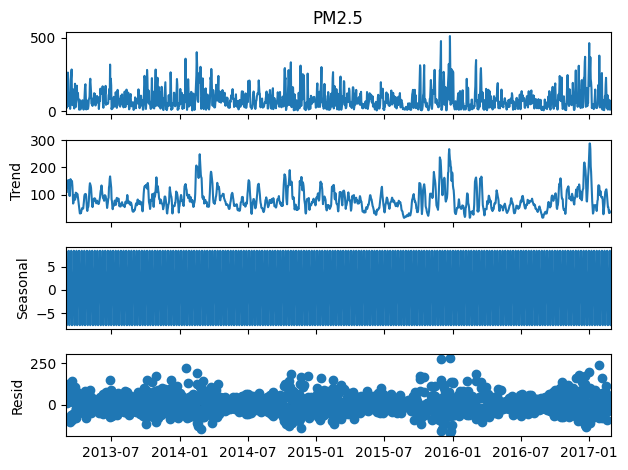

In [9]:
decompose = sm.tsa.seasonal_decompose(regions_df[Region.AOTIZHONGXIN]['PM2.5'][:24*30*12], model='aditive')
fig = decompose.plot()

(-17.57114885126214,
 4.050908104617056e-30,
 2,
 1458,
 {'1%': -3.434843038681996,
  '5%': -2.8635243777871286,
  '10%': -2.56782646544019},
 15686.547824841326)

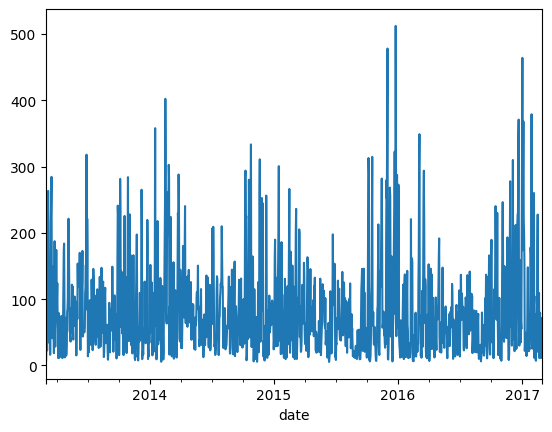

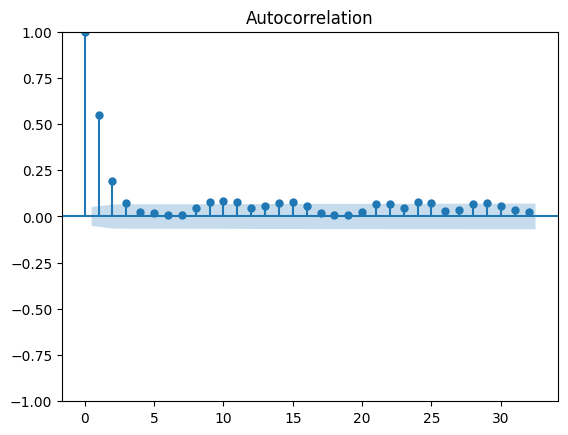

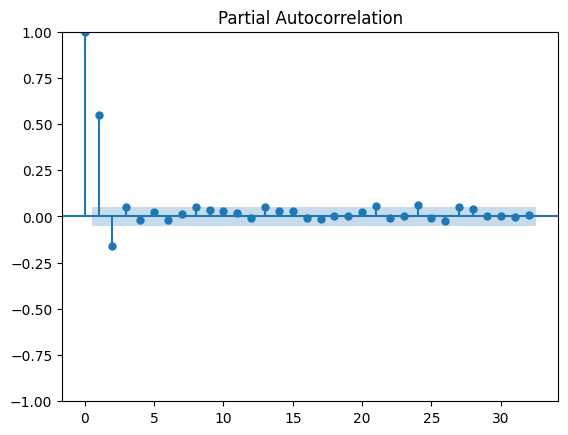

In [10]:
regions_df[Region.AOTIZHONGXIN]['PM2.5'].plot()
acf = plot_acf(regions_df[Region.AOTIZHONGXIN]['PM2.5'])
pacf = plot_pacf(regions_df[Region.AOTIZHONGXIN]['PM2.5'])
adfuller(regions_df[Region.AOTIZHONGXIN]['PM2.5'])

(-13.735789857804953,
 1.1180500248841994e-25,
 22,
 1437,
 {'1%': -3.434908816804013,
  '5%': -2.863553406963303,
  '10%': -2.5678419239852994},
 15722.097470804138)

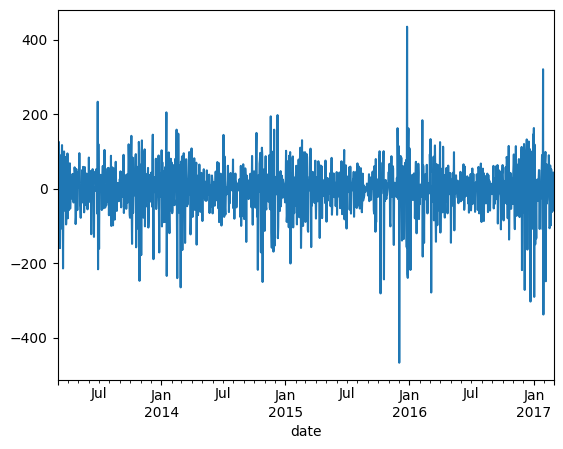

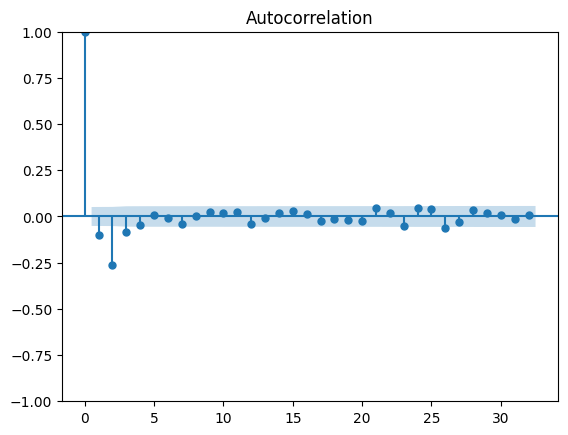

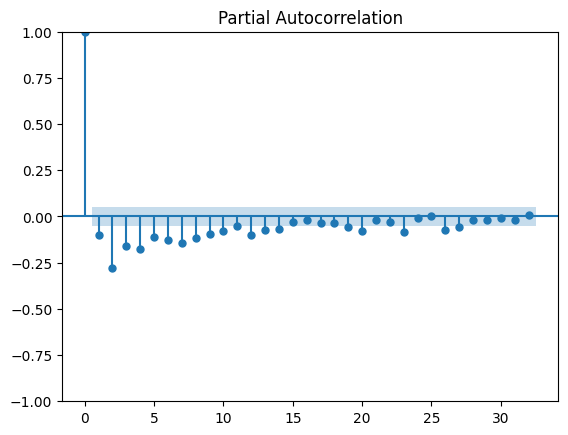

In [11]:
pm25_df = regions_df[Region.AOTIZHONGXIN]['PM2.5'].diff(1).dropna()
pm25_df.plot()
acf = plot_acf(pm25_df)
pacf = plot_pacf(pm25_df)
adfuller(pm25_df)

In [12]:
#Finding the best value for ARIMA

import itertools
p=d=q=range(0,3)
pdq = list(itertools.product(p,d,q))

for param in pdq:
    try:
        model_arima = sm.tsa.arima.ARIMA(regions_df[Region.AOTIZHONGXIN]['PM2.5'],order=param)
        model_arima_fit = model_arima.fit()
        print(param,model_arima_fit.aic)
    except:
        continue
    
# The Akaike information criterion (AIC) is an estimator of in-sample prediction error and thereby relative quality of
# statistical models for a given set of data

# It's like the mean squared error in Regression - The smaller the number, the better

/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(d

(0, 0, 0) 16534.49477700321
(0, 0, 1) 16023.656589077651
(0, 0, 2) 15980.75874941456


/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(d

(0, 1, 0) 16369.410021636284
(0, 1, 1) 16331.861482070482
(0, 1, 2) 16002.833579171038
(0, 2, 0) 17512.71093163266


/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(d

(0, 2, 1) 16368.61462615944
(0, 2, 2) 16331.617694083261
(1, 0, 0) 16012.051425718408
(1, 0, 1) 15972.192306991947


/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(d

(1, 0, 2) 15973.967567411475
(1, 1, 0) 16355.93192436391


/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(d

(1, 1, 1) 16007.788373967887


/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(1, 1, 2) 15968.18248682994
(1, 2, 0) 17221.297518622832


/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(d

(1, 2, 1) 16355.208677719073


/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-i

(1, 2, 2) 16368.076765541799
(2, 0, 0) 15977.165348684473


/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(d

(2, 0, 1) 15973.906401834254


/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(2, 0, 2) 15969.412114607701
(2, 1, 0) 16241.36217885347


/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(d

(2, 1, 1) 15973.237937595391


/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(2, 1, 2) 15970.032271469128
(2, 2, 0) 16951.716409230798


/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(d

(2, 2, 1) 16241.218713101709


/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-i

(2, 2, 2) 15976.904988506987


In [37]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [38]:
for feature in POLUTION_FEATURES:
    print(feature)
    arima = auto_arima(regions_df[Region.AOTIZHONGXIN][feature],trace=True,suppress_warnings=True)
    arima.summary()

PM2.5
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=15976.026, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=16534.495, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=16012.051, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=16023.656, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=17823.795, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=15973.967, Time=0.46 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=15980.758, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=15972.190, Time=0.32 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=15973.906, Time=0.64 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=15977.166, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=16241.700, Time=0.04 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 2.297 seconds
PM10
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16279.315, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0

In [15]:
# split test train 
train_df = regions_df[Region.AOTIZHONGXIN]['PM2.5'].iloc[:-30]
test_df = regions_df[Region.AOTIZHONGXIN]['PM2.5'].iloc[-30:]

# build ARIMA model
model_arima = sm.tsa.arima.ARIMA(train_df,order=(1,0,1))
model_arima_fit = model_arima.fit()
model_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  PM2.5   No. Observations:                 1431
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7816.865
Date:                Thu, 22 Jun 2023   AIC                          15641.729
Time:                        19:07:07   BIC                          15662.794
Sample:                    03-01-2013   HQIC                         15649.595
                         - 01-29-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.8478      4.104     20.187      0.000      74.804      90.891
ar.L1          0.3461      0.032     10.960      0.000       0.284       0.408
ma.L1          0.3042      0.034      9.046      0.000       0.238       0.370
sigma2      3256.2031     75.149     43.330      0.000    3108.915    3403.492
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1882.69
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                             1.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: >

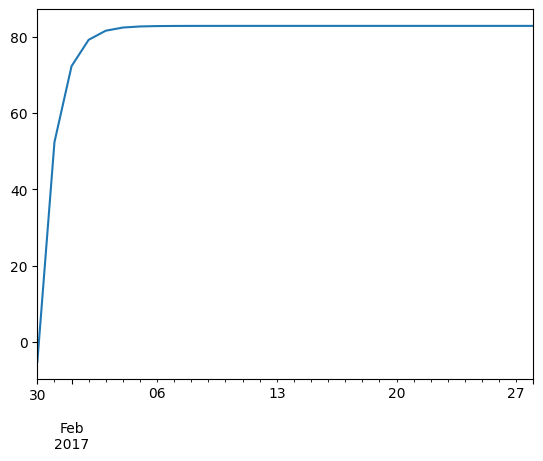

In [16]:
# make predictions
model_arima_fit.predict(start=len(train_df), end=len(test_df)+ len(train_df)-1).plot()